In [2]:
%load_ext autoreload
%autoreload 2

import wave_networks.test as test

test.hello_world()

Hello World


In [1]:
import dotenv
import wandb
import os

dotenv.load_dotenv(os.path.join('/homes/55/bwilop/wsg/private/', 'vscode-ssh.env'))
api_key = os.getenv('WANDB_API_KEY')
wandb.login(key=api_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc


True

In [3]:
# https://soundata.readthedocs.io/en/latest/source/tutorial.html
import soundata
urbansound8k = soundata.initialize('urbansound8k', data_home='/homes/55/bwilop/gdl/ablation_study_wavelet_networks/data')
# urbansound8k.download()  
# urbansound8k.validate() 

In [4]:
from wave_networks.prepare_data import *

path = "/homes/55/bwilop/gdl/ablation_study_wavelet_networks/calculated_data/preprocessed_data.pkl"
dataset_audio_timeseries = compute_dataset_audio_timeseries(path, urbansound8k)

/homes/55/bwilop/gdl/wavelet_networks/wavelet_networks/wavelet_networks_venv/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(dataset_audio_timeseries.train_data.shape)
print(dataset_audio_timeseries.validation_data.shape)
print(dataset_audio_timeseries.test_data.shape)

torch.Size([6273, 90000])
torch.Size([806, 90000])
torch.Size([1653, 90000])


In [ ]:
from wave_networks.training import train_model
from wave_networks.architecture_definitions import *

# model_name = "StandardConvolutionalNetwork"
# model_name = "2D_ConvolutionalNet"
model_name = "minimal_WaveletNetwork"
# model_name = "medium_WaveletNetwork"
# model_name = "WaveletNetwork"

if model_name == "StandardConvolutionalNetwork":
    model = StandardConvolutionalNetwork()
elif model_name == "2D_ConvolutionalNet":
    model = build_2D_ConvolutionalNet()
elif model_name == "WaveletNetwork":
    model = build_WaveletNetwork()
elif model_name == "medium_WaveletNetwork":
    model = build_medium_WaveletNetwork()
elif model_name == "minimal_WaveletNetwork":
    model = build_minimal_WaveletNetwork()
folder = "/homes/55/bwilop/gdl/ablation_study_wavelet_networks/trained_models"
train_parameters = {
    'batch_size': 16,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'max_epochs': 6, #100,
    'early_stopping_patience': 2,
}
# model = train_model(model, model_name, dataset_audio_timeseries, train_parameters, folder)

# Goal 31.03:
# Find error for S=None
# Get parameters of models and define small, medium, large models
# Run full experiments once for tiny models
# Transfer everything cleanly to colab
# [X] Finish related work section 

# Goal 01.04:
# Run experiments for medium + large
# Read paper UDL

# Goal 02.04
# Interpret models -> plot weight of scale_in vs scale_out
# Write full paper

# Goal to get a table like:
# 5 is small
# 10 is medium
# 50 is large
#                    small  medium  large
# 1D CNN
# Wavelet + 2D CNN
# Wavenet
# WeightEquiWavenet
# And then same table for training time on A100

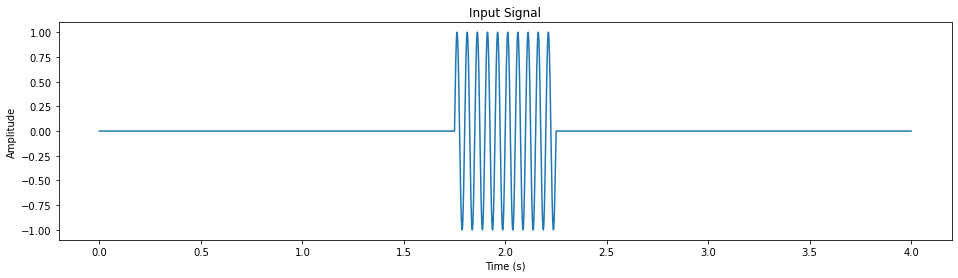

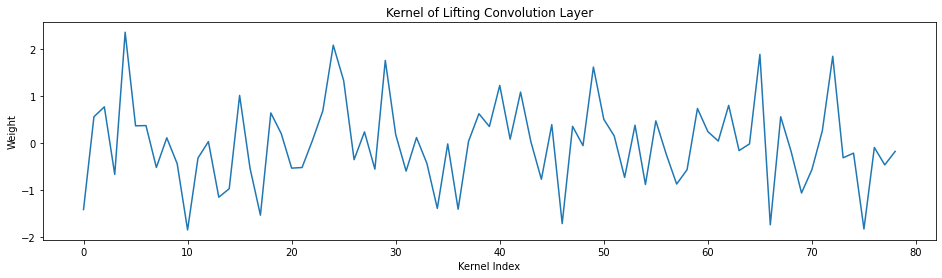

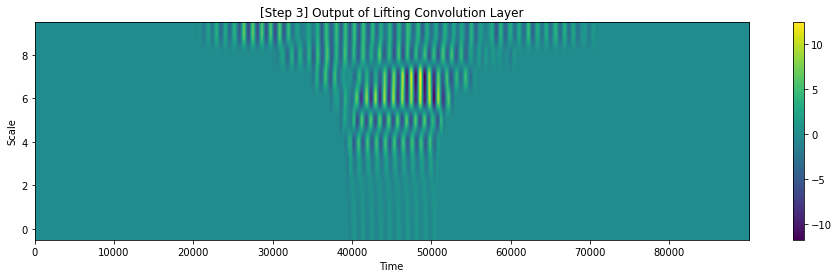

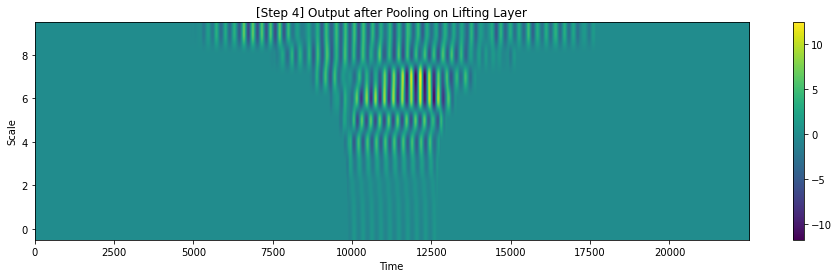

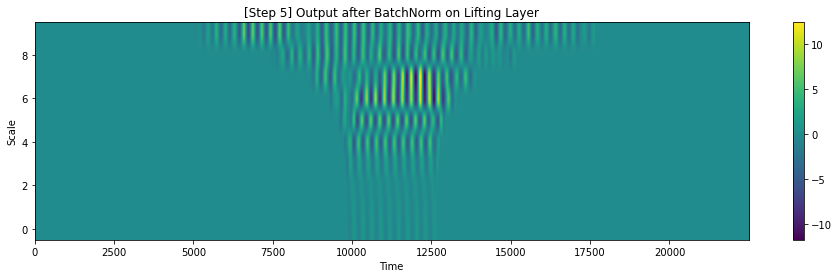

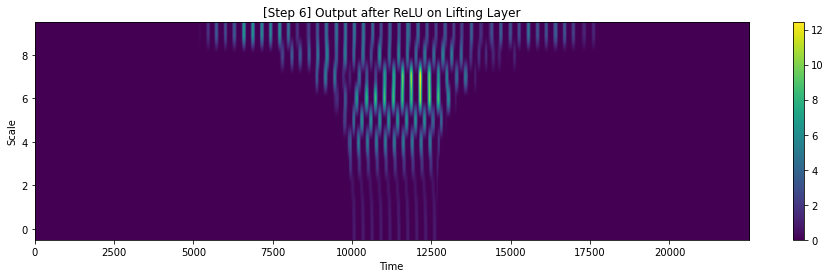

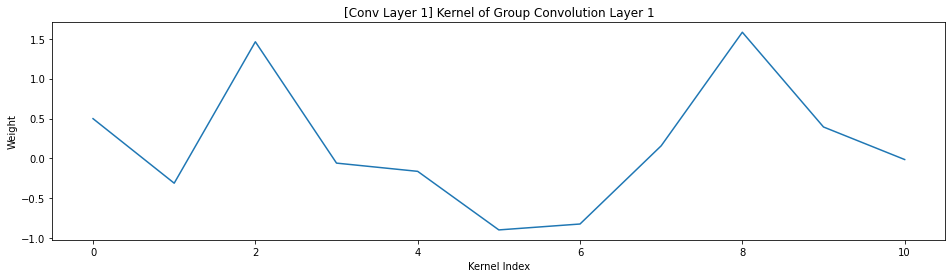

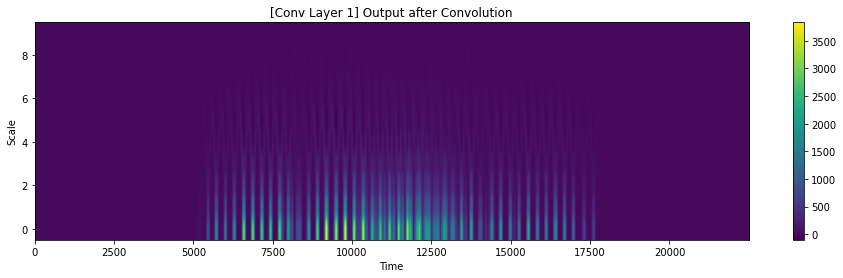

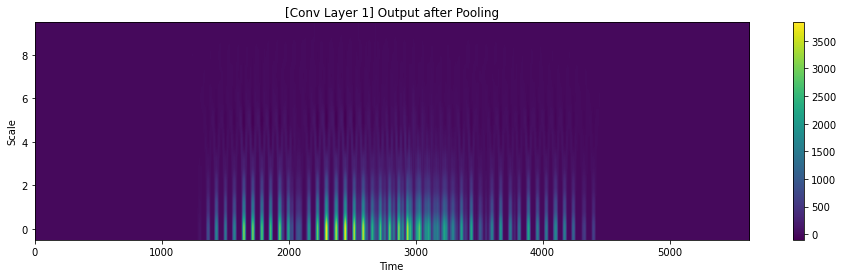

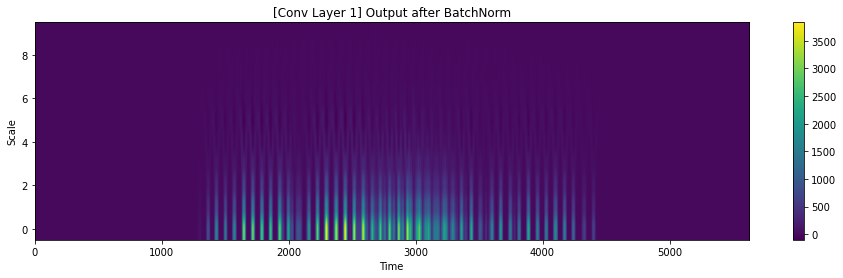

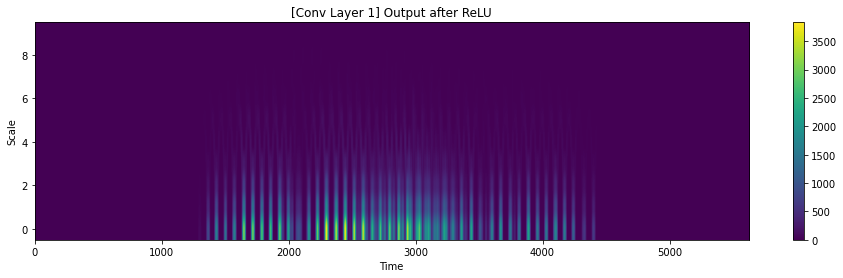

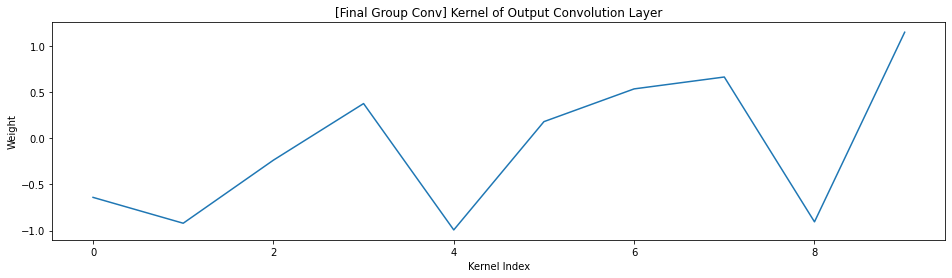

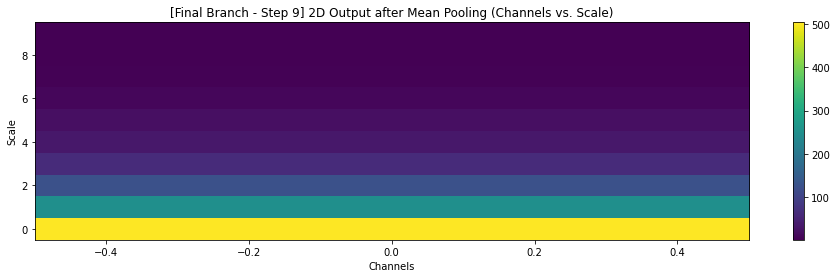

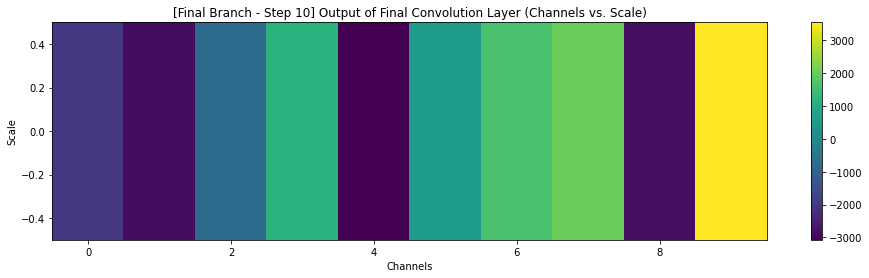

Final output logits: [-1983.3657 -2848.8586  -738.2147  1156.2256 -3072.5015   551.4858
  1647.2386  2045.0493 -2802.1675  3543.17  ]
Softmax cross-entropy losses for each target class: [5526.53564453125, 6392.0283203125, 4281.384765625, 2386.9443359375, 6615.67138671875, 2991.68408203125, 1895.9312744140625, 1498.12060546875, 6345.33740234375, 0.0]


In [7]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

from wave_networks.architecture_definitions import *

# ----- Signal Generation -----
def generate_signals(fs=22500, duration=4.0):
    total_samples = int(fs * duration)
    t_axis = np.linspace(0, duration, total_samples, endpoint=False)
    sig1 = np.zeros(total_samples, dtype=np.float32)
    sig2 = np.zeros(total_samples, dtype=np.float32)
    # Signal 1: 20Hz from 1.75s to 2.25s.
    idx1 = np.logical_and(t_axis >= 1.75, t_axis < 2.25)
    sig1[idx1] = np.sin(2 * np.pi * 20 * t_axis[idx1])
    # Signal 2: 5Hz from 1s to 3s.
    idx2 = np.logical_and(t_axis >= 1, t_axis < 3)
    sig2[idx2] = np.sin(2 * np.pi * 5 * t_axis[idx2])
    # Return as [B, 1, T]
    return t.tensor(sig1).unsqueeze(0).unsqueeze(0), t.tensor(sig2).unsqueeze(0).unsqueeze(0), t_axis


# ----- Helper Functions for Visualization -----
def plot_activation_2d(x, title, xlabel="Time", ylabel="Scale"):
    """
    Expects x to be a tensor of shape [B, C, T, S].
    If B = 1 and C = 1 then the data is squeezed to [T, S] (transposed for proper axis labeling).
    If C > 1, the channels are averaged.
    """
    x_np = x.detach().cpu().numpy()
    B, C, T, S = x_np.shape
    if B == 1:
        if C == 1:
            data = x_np.squeeze(0).squeeze(0)
        else:
            data = x_np.squeeze(0).mean(axis=0)
    else:
        if C == 1:
            data = x_np[0, 0, :, :]
        else:
            data = x_np[0].mean(axis=0)
    data = data.T  
    plt.figure(figsize=(16, 4))
    plt.imshow(data, aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.show()


def plot_kernel(kernel, title, xlabel="Kernel Index", ylabel="Weight"):
    """
    Plots a convolution kernel.
    If the kernel has shape [out_channels, in_channels, kernel_size] and in_channels==1,
    it will plot each output channel's kernel as a separate line.
    Otherwise, if the kernel is 1D after squeezing, it plots it directly.
    """
    kernel_data = kernel.detach().cpu().numpy().squeeze()
    plt.figure(figsize=(16, 4))
    if kernel_data.ndim == 1:
        plt.plot(kernel_data, label="Kernel")
    elif kernel_data.ndim == 2:
        # Assume shape is [out_channels, kernel_size]
        for i in range(kernel_data.shape[0]):
            plt.plot(kernel_data[i], label=f"Channel {i}")
        plt.legend()
    else:
        # Fallback: flatten and plot.
        plt.plot(kernel_data.flatten(), label="Flattened Kernel")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# ----- Full Forward Pass Visualization -----
def visualize_full_forward(model: t.nn.Module):
    """
    Runs a forward pass through the network and visualizes each intermediate step.
    
    Steps:
      1. Plot the input signal.
      2. Plot the kernel of the lifting convolution.
      3. x = G_lifting_layer(x) -> 2D plot.
      4. x = pool(x) -> 2D plot.
      5. x = bn_G_lifting_layer(x) -> 2D plot.
      6. x = F.relu(x) -> 2D plot.
      
      Now iterate through the conv layers same way and plot:
         - Plot the group convolution kernel.
         - x = conv(x) -> 2D plot.
         - x = pool(x) -> 2D plot.
         - x = bn(x) -> 2D plot.
         - x = F.relu(x) -> 2D plot.
      
      Then, for the final branch:
         7. x = t.mean(x, dim=2, keepdim=True)
            (Plot kernel of final group conv)
         8. [Step 9 in code] 2D heatmap after mean pooling 
            (Scale on the y-axis, Channels on the x-axis).
         9. x = G_convolutional_layer_output(x) -> 2D plot (channels vs. scale).
         10. x = t.max(x, dim=3, keepdim=True)[0] -> Print final output logits.
    """
    model.eval()
    
    # Generate signals.
    sig1, _, t_axis = generate_signals()
    
    # Step 1: Plot the input signal.
    plt.figure(figsize=(16, 4))
    plt.plot(t_axis, sig1.squeeze().detach().cpu().numpy())
    plt.title("Input Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    # Step 2: Plot kernel of lifting convolution.
    plot_kernel(model.G_lifting_layer.kernel, title="Kernel of Lifting Convolution Layer")
    
    # ----- Lifting Branch -----
    x = sig1  # [B, 1, T]
    x_lift = model.G_lifting_layer(x)  # [B, C, T, S]
    plot_activation_2d(x_lift, title="[Step 3] Output of Lifting Convolution Layer")
    
    x_pool = model.pool(x_lift)
    plot_activation_2d(x_pool, title="[Step 4] Output after Pooling on Lifting Layer")
    
    x_bn = model.bn_G_lifting_layer(x_pool)
    plot_activation_2d(x_bn, title="[Step 5] Output after BatchNorm on Lifting Layer")
    
    x_relu = F.relu(x_bn)
    plot_activation_2d(x_relu, title="[Step 6] Output after ReLU on Lifting Layer")
    
    # ----- Convolutional Branch -----
    # Now iterate through the conv layers same way and plot:
    for i in range(len(model.G_convolutional_layers)):
        conv = model.G_convolutional_layers[i]
        bn = model.bn_G_convolutional_layers[i]
        
        # Plot the kernel of the group convolution layer before its usage.
        plot_kernel(conv.kernel, title=f"[Conv Layer {i+1}] Kernel of Group Convolution Layer {i+1}")
        
        x_conv = conv(x_relu)
        plot_activation_2d(x_conv, title=f"[Conv Layer {i+1}] Output after Convolution")
        
        x_pool_conv = model.pool(x_conv)
        plot_activation_2d(x_pool_conv, title=f"[Conv Layer {i+1}] Output after Pooling")
        
        x_bn_conv = bn(x_pool_conv)
        plot_activation_2d(x_bn_conv, title=f"[Conv Layer {i+1}] Output after BatchNorm")
        
        x_relu = F.relu(x_bn_conv)
        plot_activation_2d(x_relu, title=f"[Conv Layer {i+1}] Output after ReLU")
    
    # ----- Final Output Branch -----
    # 7. x = t.mean(x, dim=2, keepdim=True)
    x_mean = t.mean(x_relu, dim=2, keepdim=True)  # [B, C, 1, S]
    
    # Plot the kernel of the final output group convolution
    plot_kernel(model.G_convolutional_layer_output.kernel, title="[Final Group Conv] Kernel of Output Convolution Layer")
    
    # 8. 2D heatmap after mean pooling (Scale on y-axis, Channels on x-axis).
    #    shape: [B, C, 1, S] => squeeze -> [C, S]
    x_mean_squeezed = x_mean.squeeze(0).squeeze(1)  # shape [C, S]
    # We want scale on the y-axis, channels on the x-axis => data shape [S, C]
    data_2d = x_mean_squeezed.detach().cpu().numpy().T  # [S, C]
    plt.figure(figsize=(16, 4))
    plt.imshow(data_2d, aspect='auto', origin='lower')
    plt.title("[Final Branch - Step 9] 2D Output after Mean Pooling (Channels vs. Scale)")
    plt.xlabel("Channels")
    plt.ylabel("Scale")
    plt.colorbar()
    plt.show()
    
    # 9. x = G_convolutional_layer_output(x) -> 2D plot (channels vs. scale).
    x_out_conv = model.G_convolutional_layer_output(x_mean)  # [B, n_classes, 1, S]
    x_out_conv_squeezed = x_out_conv.squeeze(2)  # [B, n_classes, S]
    
    # We want the same orientation: scale on y-axis, channels on x-axis.
    data_out = x_out_conv_squeezed.squeeze(0).detach().cpu().numpy().T  # shape [S, n_classes]
    plt.figure(figsize=(16, 4))
    plt.imshow(data_out, aspect='auto', origin='lower')
    plt.title("[Final Branch - Step 10] Output of Final Convolution Layer (Channels vs. Scale)")
    plt.xlabel("Channels")
    plt.ylabel("Scale")
    plt.colorbar()
    plt.show()
    
    # 10. x = t.max(x, dim=3, keepdim=True)[0] -> Print final output logits.
    x_max = t.max(x_out_conv, dim=3, keepdim=True)[0]  # [B, n_classes, 1, 1]
    x_final = x_max.squeeze()  # [n_classes]
    print("Final output logits:", x_final.detach().cpu().numpy())

    final_logits = x_final.unsqueeze(0)  # shape [1, n_classes]
    losses = []
    for i in range(model.n_classes):
        target = t.tensor([i], dtype=t.long)
        loss_i = F.cross_entropy(final_logits, target)
        losses.append(loss_i.item())
    print("Softmax cross-entropy losses for each target class:", losses)



model = build_minimal_WaveletNetwork()
visualize_full_forward(model)